In [400]:
#pip install git+https://github.com/daviddavo/lightfm

In [401]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k
from lightfm.evaluation import auc_score

In [402]:
sales_data = pd.read_json("generated_sales_dataset.json", orient="records")
print(f"Before Manipulate: {len(sales_data)}")

if "return_reason" not in sales_data.columns:
    sales_data["return_reason"] = ""
else:
    sales_data["return_reason"] = sales_data["return_reason"].fillna("")

print(f"After Manipulate: {len(sales_data)}")

Before Manipulate: 12691
After Manipulate: 12691


In [403]:
model = None
dataset = None
product_list = []
train_interactions = None
test_interactions = None

In [404]:
def train_lightfm_model(sales_data):
    global model, dataset, product_list, train_interactions, test_interactions

    users = sales_data["customer_id"].unique()
    items = sales_data["product_code"].unique()

    dataset = Dataset()
    dataset.fit(users=users, items=items)

    interactions = []
    for _, row in sales_data.iterrows():
        weight = (row["quantity"] * row["rate"]) / 5.0
        interactions.append((row["customer_id"], row["product_code"], weight))

    interactions_matrix, _ = dataset.build_interactions(interactions)

    train_interactions, test_interactions = random_train_test_split(
        interactions_matrix, test_percentage=0.2, random_state=42
    )

    model = LightFM(
        loss="warp",
        no_components=50,
        learning_rate=0.05,
        random_state=42
    )

    model.fit(train_interactions, epochs=30, num_threads=4)

    product_list = items.tolist()

    print("✅ LightFM Machine Learning model trained successfully!")


In [405]:
def checkRecordAvailable(customer_id):
    exists = customer_id in sales_data["customer_id"].values

    if not exists:
        return False, {"total_sales_records": 0, "products": []}

    summary = (
        sales_data[sales_data["customer_id"] == customer_id]
        .groupby("product_code")
        .size()
        .reset_index(name="count")
        .to_dict("records")
    )

    return True, {
        "total_sales_records": len(summary),
        "products": summary
    }


In [406]:
def find_similar_customers(customer_input, sales_data, top_k=50):
    similar = sales_data[
        (sales_data["customer_age_group"] == customer_input["customer_age_group"]) &
        (sales_data["customer_religion"] == customer_input["customer_religion"]) &
        (sales_data["family_size"] == customer_input["family_size"]) &
        (sales_data["city"] == customer_input["city"]) &
        (sales_data["province"] == customer_input["province"])
    ]

    if similar.empty:
        similar = sales_data[
            (sales_data["customer_age_group"] == customer_input["customer_age_group"]) &
            (sales_data["customer_religion"] == customer_input["customer_religion"])
        ]

    return similar["customer_id"].unique()[:top_k]

In [407]:
def predict_for_new_customer(customer_input):
    user_mapping = dataset.mapping()[0]
    similar_customers = find_similar_customers(customer_input, sales_data)

    scores_list = []

    for cust in similar_customers:
        if cust in user_mapping:
            uid = user_mapping[cust]
            scores = model.predict(uid, np.arange(len(product_list)))
            scores_list.append(scores)

    if not scores_list:
        return {"approach": "cold_start", "recommendations": []}

    avg_scores = np.mean(scores_list, axis=0)
    top_items = np.argsort(-avg_scores)[:5]

    recs = []
    for idx in top_items:
        product_code = product_list[idx]
        info = sales_data[sales_data["product_code"] == product_code].iloc[0]
        recs.append({
            "product_code": product_code,
            "product_name": info["product_name"],
            "product_category": info["product_category"],
            "unit_price": info["unit_price"],
            "score": float(avg_scores[idx])
        })

    return {"approach": "cold_start", "recommendations": recs}


In [408]:
def predict_for_existing_customer(customer_id):
    user_mapping = dataset.mapping()[0]

    if customer_id not in user_mapping:
        return {"error": "Customer not in trained model"}

    uid = user_mapping[customer_id]
    scores = model.predict(uid, np.arange(len(product_list)))

    purchased = set(
        sales_data[sales_data["customer_id"] == customer_id]["product_code"]
    )

    ranked = [
        (product_list[i], scores[i])
        for i in range(len(scores))
        if product_list[i] not in purchased
    ]

    ranked.sort(key=lambda x: x[1], reverse=True)

    recs = []
    for product_code, score in ranked[:5]:
        info = sales_data[sales_data["product_code"] == product_code].iloc[0]
        recs.append({
            "product_code": product_code,
            "product_name": info["product_name"],
            "product_category": info["product_category"],
            "unit_price": info["unit_price"],
            "score": float(score)
        })

    return {"approach": "existing_customer", "recommendations": recs}

In [409]:
def evaluate_model():
    global model, test_interactions

    k_values = [1, 3, 5, 10]
    precision_scores = []
    recall_scores = []

    for k in k_values:
        precision_scores.append(precision_at_k(model, test_interactions, k=k).mean())
        recall_scores.append(recall_at_k(model, test_interactions, k=k).mean())

    auc = auc_score(model, test_interactions).mean()

    print(f"Precision@5: {precision_scores[2]:.4f}")
    print(f"Recall@5: {recall_scores[2]:.4f}")
    print(f"AUC Score: {auc:.4f}")

    # Plot Precision@K and Recall@K
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, precision_scores, marker="o", label="Precision@K")
    plt.plot(k_values, recall_scores, marker="s", label="Recall@K")
    plt.xlabel("k (Top-N Recommendations)")
    plt.ylabel("Score")
    plt.title("LightFM Recommendation Performance")
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    plt.show()

    return precision_scores, recall_scores, auc

In [410]:
def main_fun():
    print("=== MACHINE LEARNING RECOMMENDATION SYSTEM ===\n")

    customer_input = {
        "customer_id": "CUST_009",
        "customer_age_group": "30-40",
        "customer_religion": "BUDDHIST",
        "family_size": 4,
        "city": "Ratnapura",
        "province": "Sabaragamuwa"
    }

    train_lightfm_model(sales_data)

    exists, history = checkRecordAvailable(customer_input["customer_id"])

    if exists:
        result = predict_for_existing_customer(customer_input["customer_id"])
    else:
        result = predict_for_new_customer(customer_input)

    final_output = {
        "customer_id": customer_input["customer_id"],
        "has_history": exists,
        "history_summary": history,
        **result
    }

    print("\n📦 FINAL RECOMMENDATION OUTPUT")
    print(json.dumps(final_output, indent=2))

    return final_output

In [411]:
if __name__ == "__main__":
    result = main_fun()

=== MACHINE LEARNING RECOMMENDATION SYSTEM ===

✅ LightFM Machine Learning model trained successfully!

📦 FINAL RECOMMENDATION OUTPUT
{
  "customer_id": "CUST_009",
  "has_history": false,
  "history_summary": {
    "total_sales_records": 0,
    "products": []
  },
  "approach": "cold_start",
  "recommendations": [
    {
      "product_code": "S1003",
      "product_name": "Tilapia",
      "product_category": "Fish",
      "unit_price": 1800.0,
      "score": 1.6723569631576538
    },
    {
      "product_code": "M1002",
      "product_name": "Chicken Breast",
      "product_category": "Chicken",
      "unit_price": 1800.0,
      "score": 1.046417474746704
    },
    {
      "product_code": "M1004",
      "product_name": "Chicken Mince",
      "product_category": "Chicken",
      "unit_price": 2100.0,
      "score": 0.9414396286010742
    },
    {
      "product_code": "S1004",
      "product_name": "Cod",
      "product_category": "Fish",
      "unit_price": 2000.0,
      "score": 0.8

Precision@5: 0.0582
Recall@5: 0.2860
AUC Score: 0.5976


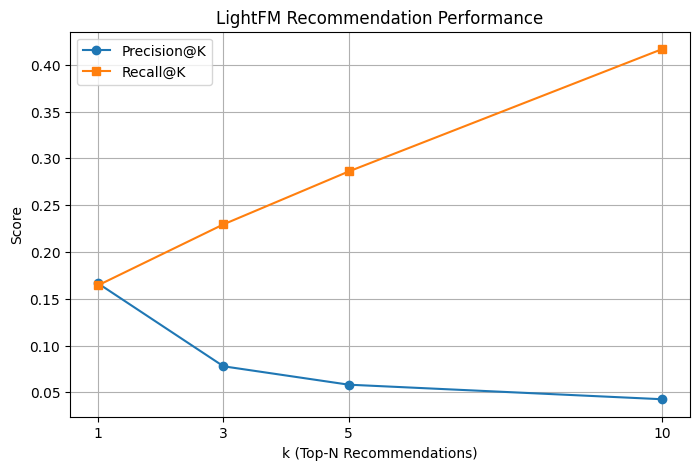

In [412]:
precision_scores, recall_scores, auc = evaluate_model()